In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

# IO

In [4]:
cs = {}

toload = dict(
    base = r"/home/mike/work/cases/2025-final-neutral-fluxlim/fnf-test/BOUT.dmp.*.nc",
    sources = r"/home/mike/work/cases/2025-final-neutral-fluxlim/fnf-test_sources/BOUT.dmp.*.nc",
    base_more_time = r"/home/mike/work/cases/2025-final-neutral-fluxlim/fnf-test_more_time/BOUT.dmp.*.nc",
)

for name, path in toload.items():
    cs[name] = xhermes.open_hermesdataset(
        datapath = path, 
        info = False, unnormalise = True)


for case in cs:
    cs[case].load()
    
    ds = cs[case]
    ds["Vd"] = ds["NVd"] / (ds["Nd"] * constants("mass_p")*2)
    cs[case] = ds

/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(
/home/mike/pyenvs/base-3.12.5/lib/python3.12/site-packages/xbout/geometries.py:226: UserWarning: Size of toroidal domain as calculated from nz*dz (dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> is not the same as 2pi*(ZMAX - ZMIN) (6.283185307179586): using value from dz
  warn(


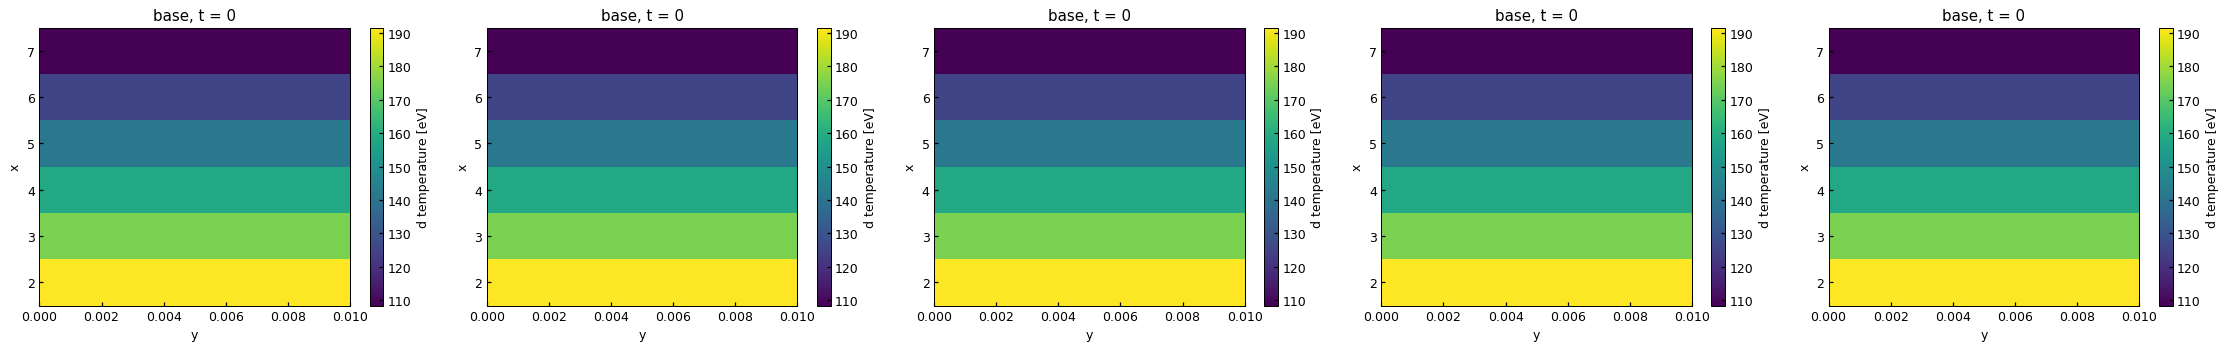

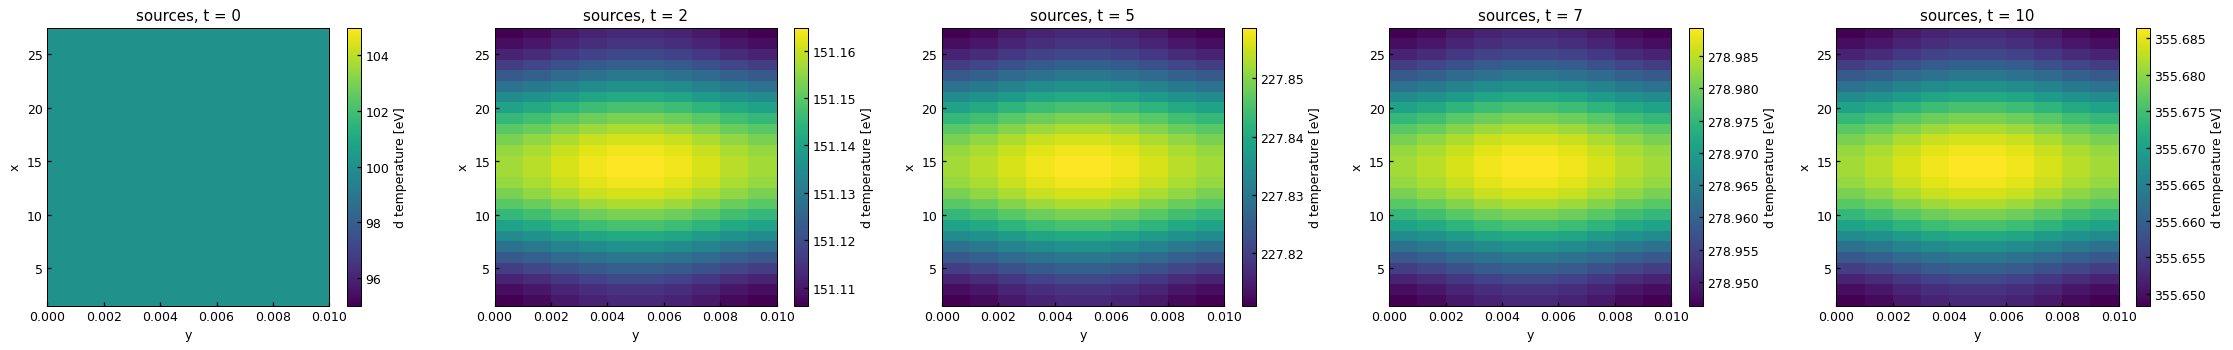

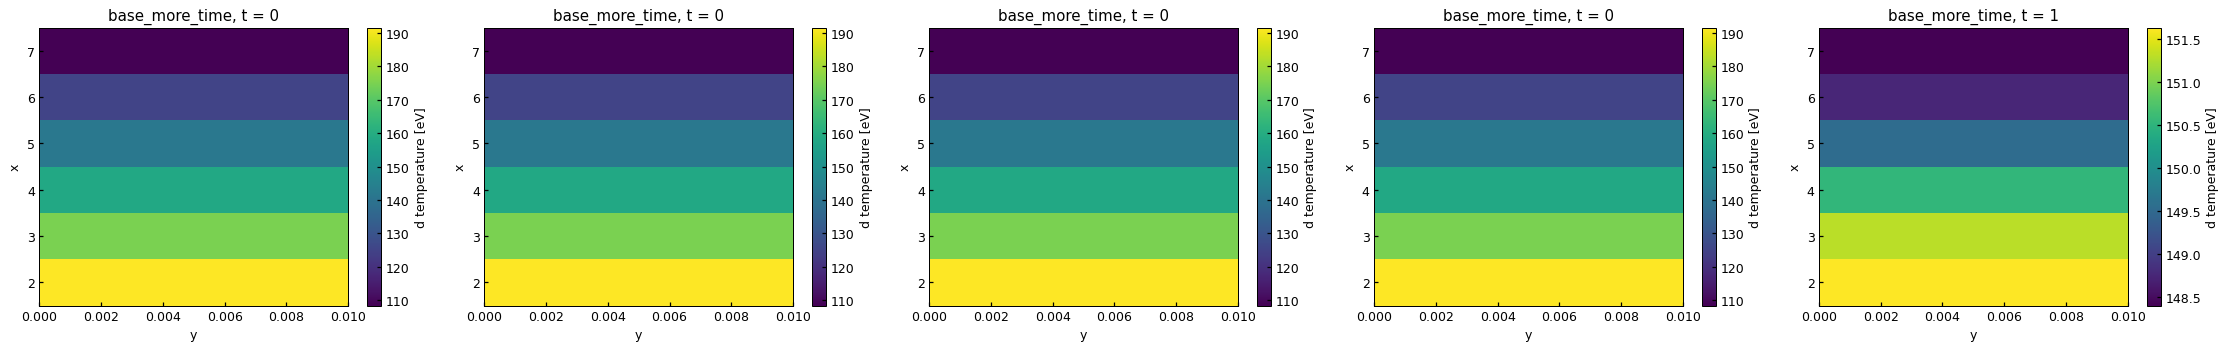

In [5]:
for name in cs:

    tlist = np.linspace(0,cs[name].sizes["t"]-1, 5, dtype=int)

    fig, axes = plt.subplots(1, len(tlist), figsize = (5*len(tlist), 4), dpi = 90)

    for i, t in enumerate(tlist):
        ds = cs[name].isel(t=t, z = 5, x = slice(2,-2))
        ds["Td"].plot(ax = axes[i], 
                      vmin = None, 
                      vmax = None
                      )

        axes[i].set_title(f"{name}, t = {t}")
        axes[i].grid(which="both", visible  = False)
        
    fig.tight_layout()

In [6]:
slices = {}

for name in cs:

    slices[name] = {}
    tind = 0

    ds = cs[name]
    tind = 0
    slices[name]["xslice"] = ds.isel(x = slice(2,-2), y = int(ds.sizes["y"]/2), z = int(ds.sizes["z"]/2), t = tind)
    slices[name]["yslice"] = ds.isel(y = slice(2,-2), x = int(ds.sizes["x"]/2), z = int(ds.sizes["z"]/2), t = tind)
    slices[name]["zslice"] = ds.isel(z = slice(2,-2), x = int(ds.sizes["x"]/2), y = int(ds.sizes["y"]/2), t = tind)

    slices[name]["xzslice"] = ds.isel(x = slice(2,-2), z = slice(2,-2), y = int(ds.sizes["y"]/2), t = tind)
    slices[name]["xyslice"] = ds.isel(x = slice(2,-2), y = slice(2,-2), z = int(ds.sizes["z"]/2), t = tind)
    slices[name]["yzslice"] = ds.isel(y = slice(2,-2), z = slice(2,-2), x = int(ds.sizes["x"]/2), t = tind)


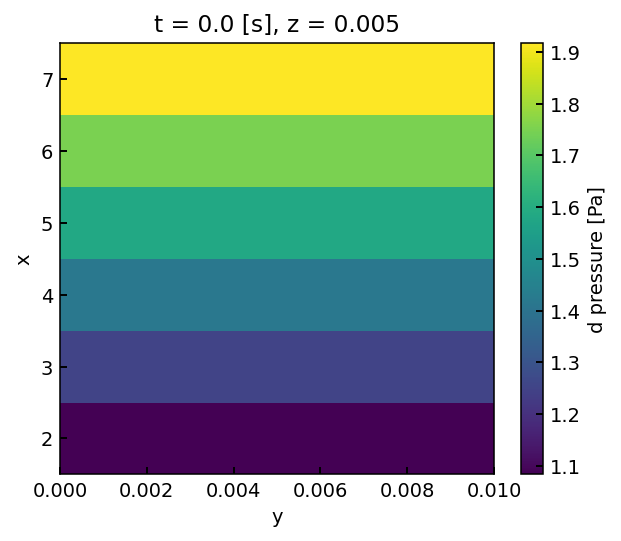

In [5]:
fig, ax = plt.subplots()
ds = cs[name].isel(t=tind, z = 5, x = slice(2,-2))
ds["Pd"].plot(ax = ax, vmin = None, vmax = None)

# Radial profiles

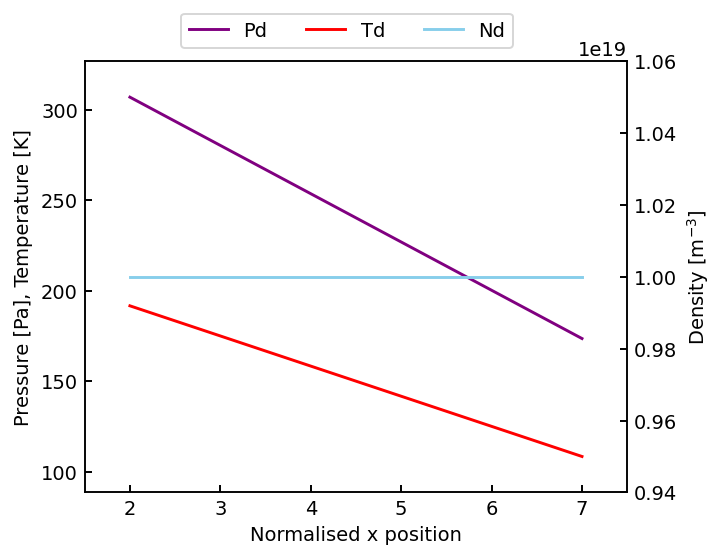

In [7]:
fig, ax = plt.subplots()

xslice = slices["base_more_time"]["xslice"]
ax2 = ax.twinx()
ax.plot(xslice["x"], xslice["Pd"], label = "Pd", color = "purple")
ax.plot(xslice["x"], xslice["Td"], label = "Td", color = "red")
ax2.plot(xslice["x"], xslice["Nd"], label = "Nd", color = "skyblue")
ax.set_xlabel("Normalised x position")
ax.set_ylabel("Pressure [Pa], Temperature [K]")
ax2.set_ylabel("Density [m$^{-3}$]")
fig.legend(bbox_to_anchor=(0.5, 0.9), loc='lower center', ncols = 3)

In [21]:
slices.keys()

dict_keys(['base'])

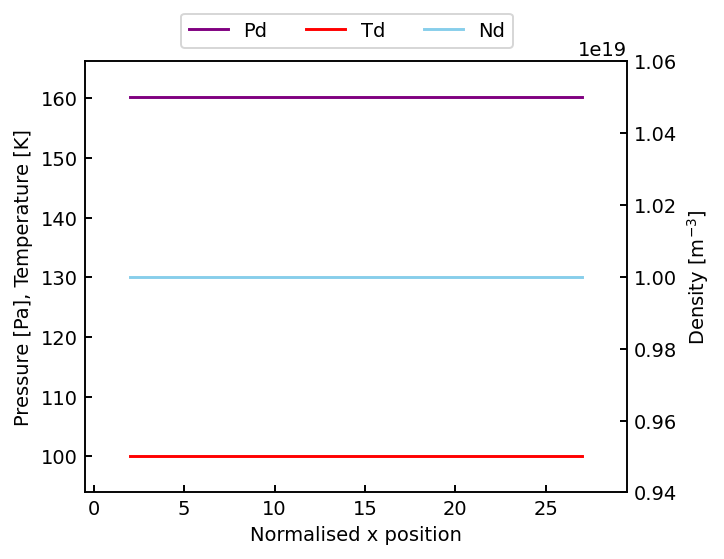

In [9]:
fig, ax = plt.subplots()

xslice = slices["sources"]["xslice"]
ax2 = ax.twinx()
ax.plot(xslice["x"], xslice["Pd"], label = "Pd", color = "purple")
ax.plot(xslice["x"], xslice["Td"], label = "Td", color = "red")
ax2.plot(xslice["x"], xslice["Nd"], label = "Nd", color = "skyblue")
ax.set_xlabel("Normalised x position")
ax.set_ylabel("Pressure [Pa], Temperature [K]")
ax2.set_ylabel("Density [m$^{-3}$]")
fig.legend(bbox_to_anchor=(0.5, 0.9), loc='lower center', ncols = 3)

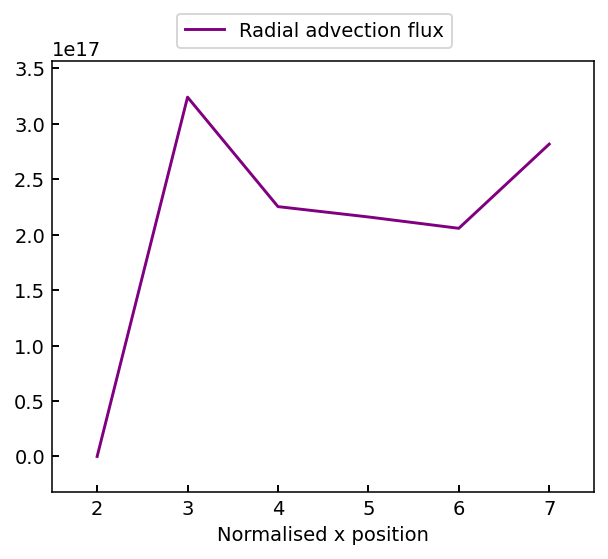

In [10]:
fig, ax = plt.subplots()
xslice = slices["base_more_time"]["xslice"]
# ax2 = ax.twinx()

ax.plot(xslice["x"], xslice["pfd_adv_perp_xlow"], label = "Radial advection flux", color = "purple")
# ax.plot(xslice["x"], xslice["Td"], label = "Td", color = "red")
# ax2.plot(xslice["x"], xslice["Nd"], label = "Nd", color = "skyblue")
ax.set_xlabel("Normalised x position")
# ax.set_ylabel("Pressure [Pa], Temperature [K]")
# ax2.set_ylabel("Density [m$^{-3}$]")
fig.legend(bbox_to_anchor=(0.5, 0.9), loc='lower center', ncols = 3)

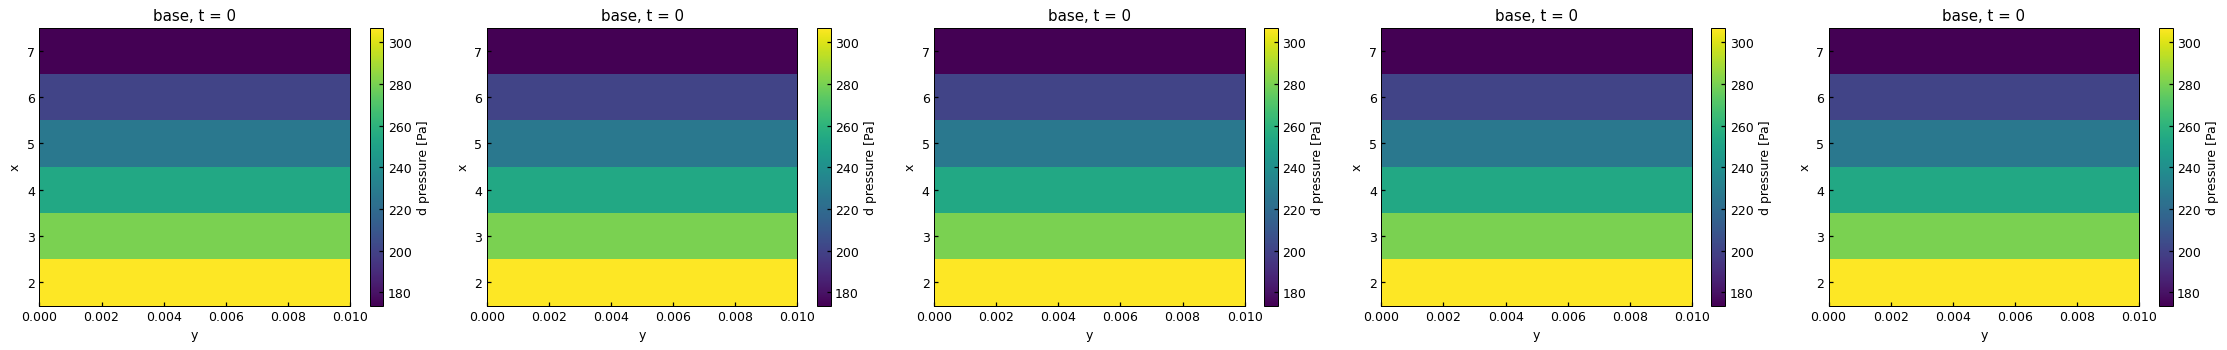

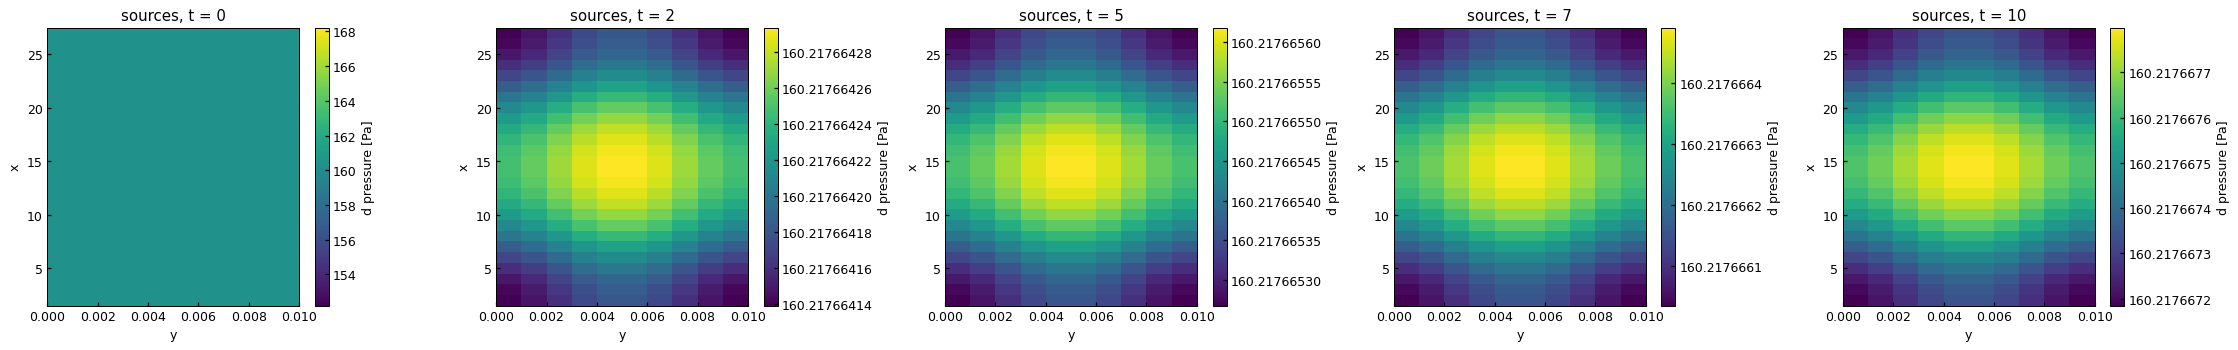

In [25]:
for name in cs:

    tlist = np.linspace(0,cs[name].sizes["t"]-1, 5, dtype=int)

    fig, axes = plt.subplots(1, len(tlist), figsize = (5*len(tlist), 4), dpi = 90)

    for i, t in enumerate(tlist):
        ds = cs[name].isel(t=t, z = 5, x = slice(2,-2))
        ds["Pd"].plot(ax = axes[i], 
                      vmin = None, 
                      vmax = None
                      )

        axes[i].set_title(f"{name}, t = {t}")
        axes[i].grid(which="both", visible  = False)
        
    fig.tight_layout()